# Automated-Essay-Grading

Essays are crucial testing tools for assessing academic achievement, integration of ideas and ability to recall, but
are expensive and time consuming to grade manually. Manual grading of essays takes up a signicant amount of
instructors' valuable time, and hence is an expensive process. Automated grading, if proven to match or exceed the
reliability of human graders, will signicantly reduce costs. The purpose of this project is to implement and train
machine learning algorithms to automatically assess and grade essay responses. These grades from the automatic
grading system should match the human grades consistently. Currently, automated grading is used instead of second
graders in some high-stakes applications, and as the only grading scheme in low stakes evaluation.

In [3]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

## Loading data

In [5]:
#dataframe = pd.read_csv('all_essaysets.csv', encoding = 'latin-1')
dataframe = pd.read_csv('training.tsv.txt', encoding = 'latin-1', sep='\t')
dataframe.describe()

,essay_id,essay_set,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
count,12976.000000,12976.000000,12976.000000,12976.000000,128.000000,12976.000000,1800.000000,1800.000000,1800.000000,2292.000000,...,2292.000000,2292.000000,723.000000,723.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,10295.395808,4.179485,4.127158,4.137408,37.828125,6.800247,3.333889,3.330556,3.333889,2.444154,...,2.635689,2.710297,3.777317,3.589212,3.945312,3.890625,4.078125,3.992188,3.843750,3.617188
std,6309.074105,2.136913,4.212544,4.264330,5.240829,8.970705,0.729103,0.726807,0.729103,1.211730,...,1.142566,1.045795,0.689401,0.693256,0.643668,0.630390,0.622535,0.509687,0.538845,0.603417
min,1.000000,1.000000,0.000000,0.000000,20.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000
25%,4438.750000,2.000000,2.000000,2.000000,36.000000,2.000000,3.000000,3.000000,3.000000,2.000000,...,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000
50%,10044.500000,4.000000,3.000000,3.000000,40.000000,3.000000,3.000000,3.000000,3.000000,2.000000,...,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
75%,15681.250000,6.000000,4.000000,4.000000,40.000000,8.000000,4.000000,4.000000,4.000000,3.000000,...,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,21633.000000,8.000000,30.000000,30.000000,50.000000,60.000000,4.000000,4.000000,4.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000


In [6]:
dataframe.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Methods

In [7]:
# selecting which set to be used 1-8
# in order to combine them all assign set number to 9
def select_set(dataframe,setNumber):
    if setNumber == 9:
        dataframe2 = dataframe[dataframe.essay_set ==1]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        for i in range(1,9):
            dataframe2 = dataframe[dataframe.essay_set == i]
            texts = texts.append(dataframe2['essay'])
            s = dataframe2['domain1_score']
            s = s.apply(lambda x: (x*3)/s.max())
            scores = scores.append(s)
    else:
        dataframe2 = dataframe[dataframe.essay_set ==setNumber]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
    return texts, scores

In [8]:
# get histogram plot of scores and average score
def get_hist_avg(scores,bin_count):
    print(sum(scores)/len(scores))
    scores.hist(bins=bin_count)

In [9]:
#average word length for a text
def avg_word_len(text):
    clean_essay = re.sub(r'\W', ' ', text)
    words = nltk.word_tokenize(clean_essay)
    total = 0
    for word in words:
        total = total + len(word)
    average = total / len(words)
    
    return average

# word count in a given text
def word_count(text):
    clean_essay = re.sub(r'\W', ' ', text)
    return len(nltk.word_tokenize(clean_essay))

# char count in a given text
def char_count(text):
    return len(re.sub(r'\s', '', str(text).lower()))

# sentence count in a given text
def sent_count(text):
    return len(nltk.sent_tokenize(text))

#tokenization of texts to sentences
def sent_tokenize(text):
    stripped_essay = text.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
            tokens = nltk.word_tokenize(clean_sentence)
            tokenized_sentences.append(tokens)
    return tokenized_sentences


# lemma, noun, adjective, verb, adverb count for a given text

def count_lemmas(text):
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0   
    lemmas = []
    lemmatizer = WordNetLemmatizer()
    tokenized_sentences = sent_tokenize(text)
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            
            if pos_tag.startswith('N'): 
                noun_count += 1
                pos = wordnet.NOUN
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                adj_count += 1
                pos = wordnet.ADJ
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                verb_count += 1
                pos = wordnet.VERB
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                adv_count += 1
                pos = wordnet.ADV
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return noun_count, adj_count, verb_count, adv_count, lemma_count

In [10]:
def token_word(text):
    text = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return tokens

In [11]:
def misspell_count(text):
    spell = SpellChecker()
    # find those words that may be misspelled
    misspelled = spell.unknown(token_word(text))
    #print(misspelled)
    return len(misspelled)

In [12]:
def create_features(texts):
    data = pd.DataFrame(columns=('Average_Word_Length','Sentence_Count','Word_Count',
                                'Character_Count', 'Noun_Count','Adjective_Count',
                                'Verb_Count', 'Adverb_Count', 'Lemma_Count' , 'Misspell_Count'
                                 ))

    data['Average_Word_Length'] = texts.apply(avg_word_len)
    data['Sentence_Count'] = texts.apply(sent_count)
    data['Word_Count'] = texts.apply(word_count)
    data['Character_Count'] = texts.apply(char_count)
    temp=texts.apply(count_lemmas)
    noun_count,adj_count,verb_count,adverb_count,lemma_count = zip(*temp)
    data['Noun_Count'] = noun_count
    data['Adjective_Count'] = adj_count
    data['Verb_Count'] = verb_count
    data['Adverb_Count'] = adverb_count
    data['Lemma_Count'] = lemma_count
    data['Misspell_Count'] = texts.apply(misspell_count)
    return data

In [13]:
def data_prepare(texts,scores):
    #create features from the texts and clean non graded essays
    data = create_features(texts)
    data.describe()
    t1=np.where(np.asanyarray(np.isnan(scores)))
    scores=scores.drop(scores.index[t1])
    data=data.drop(scores.index[t1])
    
    #scaler = MinMaxScaler()
    #data = scaler.fit_transform(data)

    #train test split
    X_train, X_test, y_train, y_test = train_test_split(data, scores, test_size = 0.3)

    #checking is there any nan cells
    print(np.any(np.isnan(scores)))
    print(np.all(np.isfinite(scores)))
    return X_train, X_test, y_train, y_test, data

In [14]:
def lin_regression(X_train,y_train,X_test,y_test):
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    # The mean squared error
    mse=mean_squared_error(y_test, y_pred)
    mse_per= 100*mse/3
    print("Mean squared error: {}".format(mse))
    print("Mean squared error in percentage: {}".format(mse_per))
    #explained variance score
    print('Variance score: {}'.format(regr.score(X_test, y_test)))

In [15]:
def adaBoost_reg(X_train,y_train,X_test,y_test):
    #regr = RandomForestRegressor(max_depth=2, n_estimators=300)
    #regr = SVR(gamma='scale', C=1, kernel='linear')
    regr = AdaBoostRegressor()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # The mean squared error
    mse=mean_squared_error(y_test, y_pred)
    mse_per= 100*mse/3
    print("Mean squared error: {}".format(mse))
    print("Mean squared error in percentage: {}".format(mse_per))
    #explained variance score
    print('Variance score: {}'.format(regr.score(X_test, y_test)))

    feature_importance = regr.feature_importances_

    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_names = list(('Average_Word_Length','Sentence_Count','Word_Count',
                                'Character_Count', 'Noun_Count','Adjective_Count',
                                'Verb_Count', 'Adverb_Count', 'Lemma_Count' ,'Misspell_Count'
                                 ))
    feature_names = np.asarray(feature_names)
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, feature_names[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [16]:
# convert numerical scores to labels
# (0-1.5) bad (1.5-2.3) average (2.3-3) good
# bad:    '0'
# average '1'
# good    '2'
def convert_scores(scores):
    def mapping(x):
        if x < np.percentile(scores,25):
            return 0
        elif x < np.percentile(scores,75):
            return 1
        else:
            return 2
    return scores.apply(mapping)

In [17]:
# selecting which set to be used 1-8
# in order to combine them all assign set number to 9
def select_set_classification(dataframe,setNumber):
    if setNumber == 9:
        dataframe2 = dataframe[dataframe.essay_set ==1]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        scores = convert_scores(scores)
        for i in range(1,9):
            dataframe2 = dataframe[dataframe.essay_set == i]
            texts = texts.append(dataframe2['essay'])
            s = dataframe2['domain1_score']
            s = s.apply(lambda x: (x*3)/s.max())
            s = convert_scores(s)
            scores = scores.append(s)
    else:
        dataframe2 = dataframe[dataframe.essay_set ==setNumber]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        scores = convert_scores(scores)
    return texts, scores

## Dataset selection

2.132080762759394
False
True


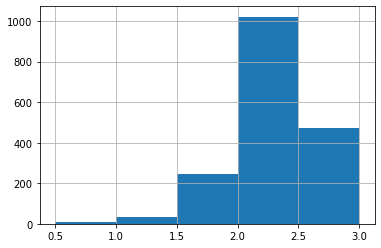

In [19]:
# 1-8
# 9:all sets combined
texts, scores = select_set(dataframe,1)
get_hist_avg(scores,5)
X_train, X_test, y_train, y_test, data = data_prepare(texts,scores)

## Regression Analysis

Testing for Linear Regression 

Mean squared error: 0.042805777623462285
Mean squared error in percentage: 1.4268592541154097
Variance score: 0.7114033141688536
Testing for Adaboost Regression 

Mean squared error: 0.04267092215508962
Mean squared error in percentage: 1.4223640718363209
Variance score: 0.7123125101559211


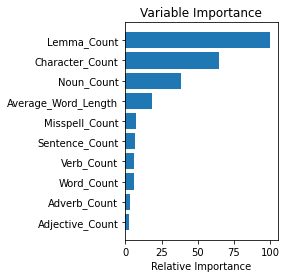

In [20]:
print('Testing for Linear Regression \n')
lin_regression(X_train,y_train,X_test,y_test)
print('Testing for Adaboost Regression \n')
adaBoost_reg(X_train,y_train,X_test,y_test)

## Dataset selection 2

In [21]:
# 1-8
# 9:all sets combined
texts, scores = select_set_classification(dataframe,1)
X_train, X_test, y_train, y_test, data = data_prepare(texts,scores)

False
True


## Classification analysis

In [32]:
a=[0.1,1,10,100,500,1000]
for b in a:
    clf = svm.SVC(C=b, gamma=0.00001)
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    print (b)
    print (clf.score(X_test,y_test))
    print (np.mean(cross_val_score(clf, X_train, y_train, cv=3)))

0.1
0.788785046728972
0.7764423076923078
1
0.7962616822429907
0.782051282051282
10
0.8018691588785046
0.7860576923076922
100
0.811214953271028
0.7820512820512819
500
0.811214953271028
0.7748397435897436
1000
0.8037383177570093
0.7740384615384616


In [33]:
clf = svm.SVC(C=100, gamma=0.00001)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print('Cohen’s kappa score: {}'.format(cohen_kappa_score(y_test,y_pred)))

Cohen’s kappa score: 0.6617950804281154


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        89
           1       0.82      0.87      0.84       309
           2       0.78      0.74      0.76       137

    accuracy                           0.81       535
   macro avg       0.81      0.77      0.79       535
weighted avg       0.81      0.81      0.81       535



In [35]:
import warnings
warnings.filterwarnings('ignore')

## Data Analysis

<AxesSubplot:xlabel='domain1_score', ylabel='count'>

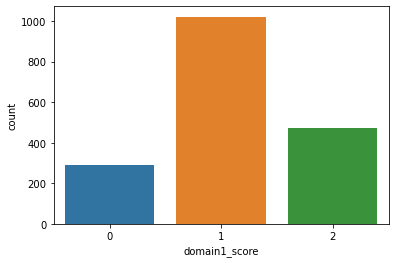

In [36]:
sns.countplot(scores)

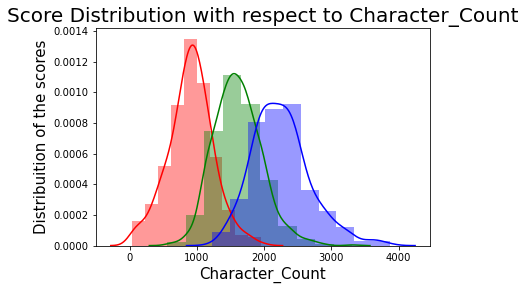

In [37]:
zero = data[(data["Character_Count"] > 0) & (scores == 0)]
one = data[(data["Character_Count"] > 0) & (scores == 1)]
two = data[(data["Character_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Character_Count"], bins=10, color='r')
sns.distplot(one["Character_Count"], bins=10, color='g')
sns.distplot(two["Character_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to Character_Count",fontsize=20)
plt.xlabel("Character_Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

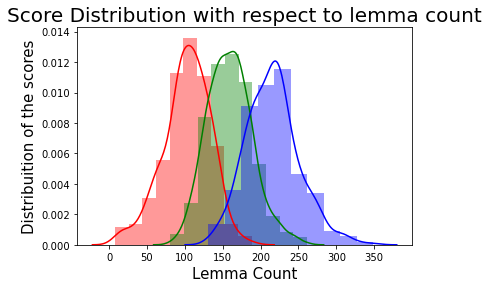

In [38]:
zero = data[(data["Lemma_Count"] > 0) & (scores == 0)]
one = data[(data["Lemma_Count"] > 0) & (scores == 1)]
two = data[(data["Lemma_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Lemma_Count"], bins=10, color='r')
sns.distplot(one["Lemma_Count"], bins=10, color='g')
sns.distplot(two["Lemma_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to lemma count",fontsize=20)
plt.xlabel("Lemma Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

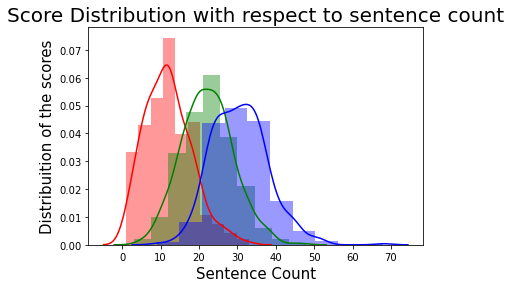

In [39]:
zero = data[(data["Sentence_Count"] > 0) & (scores == 0)]
one = data[(data["Sentence_Count"] > 0) & (scores == 1)]
two = data[(data["Sentence_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Sentence_Count"], bins=10, color='r')
sns.distplot(one["Sentence_Count"], bins=10, color='g')
sns.distplot(two["Sentence_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to sentence count",fontsize=20)
plt.xlabel("Sentence Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

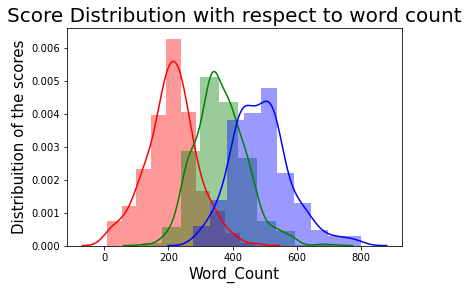

In [40]:
zero = data[(data["Word_Count"] > 0) & (scores == 0)]
one = data[(data["Word_Count"] > 0) & (scores == 1)]
two = data[(data["Word_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Word_Count"], bins=10, color='r')
sns.distplot(one["Word_Count"], bins=10, color='g')
sns.distplot(two["Word_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to word count",fontsize=20)
plt.xlabel("Word_Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

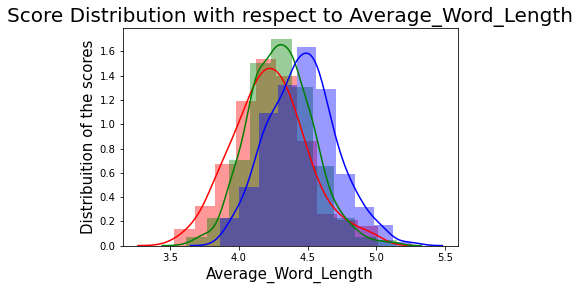

In [41]:
zero = data[(data["Average_Word_Length"] > 0) & (scores == 0)]
one = data[(data["Average_Word_Length"] > 0) & (scores == 1)]
two = data[(data["Average_Word_Length"] > 0) & (scores == 2)]
sns.distplot(zero["Average_Word_Length"], bins=10, color='r')
sns.distplot(one["Average_Word_Length"], bins=10, color='g')
sns.distplot(two["Average_Word_Length"], bins=10, color='b')
plt.title("Score Distribution with respect to Average_Word_Length",fontsize=20)
plt.xlabel("Average_Word_Length",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

### Kappa Score Reliability

According to Cohen's original article, values ≤ 0 as indicating no agreement and 0.01–0.20 as none to slight, 0.21–0.40 as fair, 0.41– 0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1.00 as almost perfect agreement. McHugh says that many texts recommend 80% agreement as the minimum acceptable interrater agreement.

## Summary

Evaluation and grading of essays comes as a major problem with human evaluation being slow , tedious , time taking. Automated grading if proven effective will not only reduce the time for assessment but comparing it with human scores will also make the score realistic. We developed an automated essay assessment system by use of machine learning techniques and Neural networks by classifying a corpus of textual entities into a small number of discrete categories, corresponding to possible grades.